In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score
from itertools import product
from scipy.sparse import coo_matrix
from utils_plot import *

In [16]:
# 1. Data Normalization
def preprocessing(alpha1, alpha2, N, ampl_threshold=0):

    targetnames = np.array(list(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
     
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    #N_norm = N - np.mean(N, axis=0, keepdims=True) #We will optimize the sparse matrix

    return alpha1_norm, alpha2_norm, N, targetnames_filtered, tf_names_filtered

In [17]:
# 2 Define Ridge Regression Model with Trainable Sparse W
class TrainableModel(nn.Module):
    def __init__(self, N, alpha, num_tfs, num_thetas, lambda1=0.01, lambda2=0.01):
        super(TrainableModel, self).__init__()
        
        self.lambda1 = lambda1  # L1 regularization for W
        self.lambda2 = lambda2  # L2 regularization for A

        # Convert N to COO format
        sparse_matrix = coo_matrix(N)

        # Get the nonzero indices and values
        self.i = torch.tensor(sparse_matrix.row, dtype=torch.long)
        self.j = torch.tensor(sparse_matrix.col, dtype=torch.long)
        values = torch.tensor(sparse_matrix.data, dtype=torch.float32)

        # Create W as a trainable vector for the non-zero elements of N
        self.W = nn.Parameter(torch.randn(len(values)) * 0.01)
        #self.W = nn.Parameter(values)

        # Trainable A matrix
        self.A = nn.Parameter(torch.randn(num_tfs, num_thetas) * 0.01)

        # Store original shape
        self.num_genes, self.num_tfs = N.shape

    def forward(self):
        # Create a sparse tensor for W
        W_sparse = torch.sparse_coo_tensor(
            indices=torch.stack([self.i, self.j]), 
            values=self.W, 
            size=(self.num_genes, self.num_tfs)
        )

        # Convert to dense tensor
        W_dense_tensor = W_sparse.to_dense()

        return torch.matmul(W_dense_tensor, self.A)  # Predicted alpha

    def loss(self, alpha_true):
        alpha_pred = self.forward()
        
        mse_loss = torch.mean((alpha_true - alpha_pred) ** 2)
        
        # Regularization
        l1_loss = torch.sum(torch.abs(self.W))  # L1 on W
        l2_loss = torch.sum(self.A ** 2)  # L2 on A

        total_loss = mse_loss + self.lambda1 * l1_loss + self.lambda2 * l2_loss
        
        return total_loss

In [18]:
def train_model(N, alpha, lambda1, lambda2, num_epochs=1000, lr=0.01):
    num_genes, num_tfs = N.shape
    num_thetas = alpha.shape[1]
    
    model = TrainableModel(N, alpha, num_tfs, num_thetas, lambda1, lambda2)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = model.loss(alpha)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    # Convert learned W back to dense matrix
    W_dense = torch.sparse_coo_tensor(
        indices=torch.stack([model.i, model.j]), 
        values=model.W.detach(), 
        size=(num_genes, num_tfs)
    ).to_dense().numpy()

    return W_dense, model.A.detach().numpy()

In [19]:
# 4. Cross-Validation for Lambda Optimization
def cross_val_lambda(N, alpha1, alpha2, lambda1_values, lambda2_values):
    best_lambda1, best_lambda2, best_EV = None, None, -np.inf

    for lambda1, lambda2 in product(lambda1_values, lambda2_values):
        print(f"Testing lambda1 = {round(lambda1,3)}, lambda2 = {round(lambda2,3)}")

        # Train on alpha1, test on alpha2
        W1, A1 = train_model(N, alpha1, lambda1, lambda2)
        R_test1 = W1 @ A1
        EV1 = explained_variance_score(alpha2, R_test1)

        # Train on alpha2, test on alpha1
        W2, A2 = train_model(N, alpha2, lambda1, lambda2)
        R_test2 = W2 @ A2
        EV2 = explained_variance_score(alpha1, R_test2)

        avg_EV = (EV1 + EV2) / 2
        print(f"Lambda1={lambda1:.3f}, Lambda2={lambda2:.3f}, EV={avg_EV*100:.2f}%\n")

        if avg_EV > best_EV:
            best_lambda1, best_lambda2, best_EV = lambda1, lambda2, avg_EV

    print(f"Best λ1 = {best_lambda1:.3f}, Best λ2={best_lambda2:.3f}, Best EV={best_EV*100:.2f}%\n")
    return best_lambda1, best_lambda2

In [20]:
# 5. Cross train for best model
def cross_train(N, alpha1, alpha2, best_lambda1, best_lambda2):
    print("Training on α1, testing on α2...")
    W1, A1 = train_model(N, alpha1, best_lambda1, best_lambda2)
    R_test1 = W1 @ A1
    EV1 = explained_variance_score(alpha2.numpy(), R_test1)

    print("Training on α2, testing on α1...")
    W2, A2 = train_model(N, alpha2, best_lambda1, best_lambda2)
    R_test2 = W2 @ A2
    EV2 = explained_variance_score(alpha1.numpy(), R_test2)

    avg_EV = (EV1 + EV2) / 2
    print(f"Average EV: {avg_EV*100:.2f}%")
    
    return W1, A1, W2, A2

In [21]:
# Load Data & Run
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00

# Define Lambda Values
#lambda1_values = np.logspace(-2, 2, 5)
#lambda2_values = np.logspace(-2, 2, 5)
lambda1_values = [0.001]
lambda2_values = [0.001]

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.2
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape, "\n")

N_tensor = torch.tensor(N_norm, dtype=torch.float32)  # (genes, TFs)
alpha1_tensor = torch.tensor(alpha1_norm, dtype=torch.float32)  # (genes, thetas)
alpha2_tensor = torch.tensor(alpha2_norm, dtype=torch.float32)  # (genes, thetas)

# Optimize Lambda
best_lambda1, best_lambda2 = cross_val_lambda(N_tensor, alpha1_tensor, alpha2_tensor, lambda1_values, lambda2_values)

# Train and Cross-Test
W1, A1, W2, A2 = cross_train(N_tensor, alpha1_tensor, alpha2_tensor, best_lambda1, best_lambda2)

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 10
Kept genes: 812 (ampl > 0.2)
(812, 100) (812, 100) (812, 360) 

Testing lambda1 = 0.001, lambda2 = 0.001
Epoch 0: Loss = 20.3797
Epoch 100: Loss = 7.8936
Epoch 200: Loss = 4.2316
Epoch 300: Loss = 2.5723
Epoch 400: Loss = 1.6669
Epoch 500: Loss = 1.1330
Epoch 600: Loss = 0.7958
Epoch 700: Loss = 0.5864
Epoch 800: Loss = 0.4522
Epoch 900: Loss = 0.3630
Epoch 0: Loss = 20.3731
Epoch 100: Loss = 7.8869
Epoch 200: Loss = 4.2249
Epoch 300: Loss = 2.5659
Epoch 400: Loss = 1.6603
Epoch 500: Loss = 1.1263
Epoch 600: Loss = 0.7891
Epoch 700: Loss = 0.5798
Epoch 800: Loss = 0.4456
Epoch 900: Loss = 0.3561
Lambda1=0.001, Lambda2=0.001, EV=0.33%

Best λ1 = 0.001, Best λ2=0.001, Best EV=0.33%

Training on α1, testing on α2...
Epoch 0: Loss = 20.3791
Epoch 100: Loss = 7.8935
Epoch 200: Loss = 4.2316
Epoch 300: Loss = 2.5722
Epoch 400: Loss = 1.6669
Epoch 500: Loss = 1.1329
Epoch 600: Loss = 0.7960
Epoch 700: Los

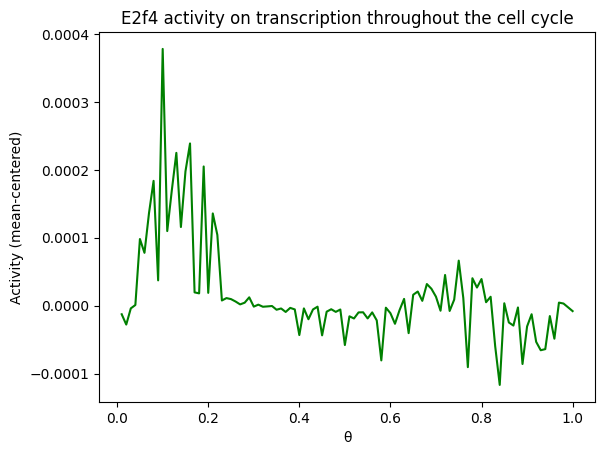

In [22]:
BP_nb = np.where(tf_names == 'E2f4')[0][0]
plot_binding_protein_activity(tf_names, A1, process, theta_smooth, BP_nb=BP_nb)

In [26]:
W1 @ A1

array([[ 5.4120058e-03,  8.5554682e-03,  1.1681250e-02, ...,
        -3.6698035e-03, -7.2894501e-04,  2.3102551e-03],
       [-2.4311528e-06,  5.7441014e-07,  2.9886185e-06, ...,
        -1.0058752e-05, -7.5839857e-06, -5.0237936e-06],
       [-1.6800404e-05, -1.2186228e-05, -7.3543129e-06, ...,
        -2.5935702e-05, -2.3499135e-05, -2.0476080e-05],
       ...,
       [ 8.4791245e-06,  1.8387458e-05,  2.8391649e-05, ...,
        -2.0792932e-05, -1.1363698e-05, -1.5710797e-06],
       [ 3.2366936e-06,  6.0299694e-06,  8.8820734e-06, ...,
        -4.6125729e-06, -2.1173976e-06,  5.2771378e-07],
       [ 9.2805341e-02,  1.1402892e-01,  1.3464387e-01, ...,
         2.8024692e-02,  4.9522657e-02,  7.1206167e-02]], dtype=float32)

Train


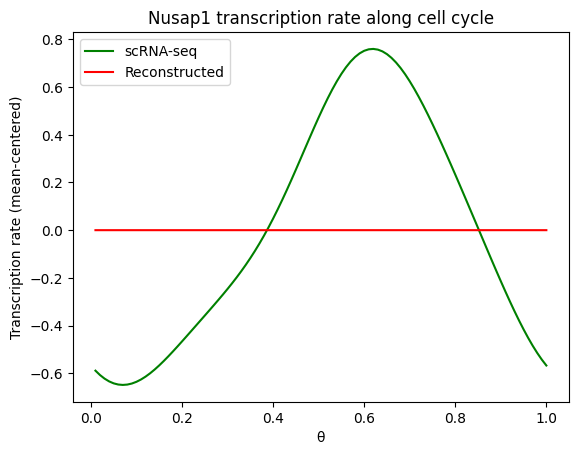

Test


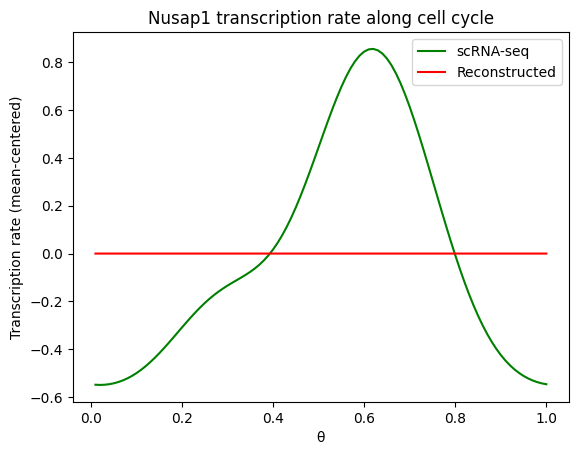

In [29]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 12
print("Train")
plot_rate_comparison(targetnames, alpha1_tensor, W1 @ A1, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames, alpha2_tensor, W1 @ A1, process, theta_smooth, target_nb=n)